## Cell 1: Imports & Configuration

Sets up your environment and professional display settings.

In [1]:
# 1. IMPORTS & CONFIGURATION
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Professional Tip: Set pandas display options to see all columns during inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load Dataset
df = sns.load_dataset('titanic')

print("Data Loaded. Shape:", df.shape)

Data Loaded. Shape: (891, 15)


## Cell 2: The "Sanity Check" (Audit)
Checks for duplicates and distinct values to ensure data integrity.

In [2]:
# Check for full row duplicates (common in SQL extraction errors)
duplicates = df.duplicated().sum()
print(f"Duplicate Rows Detected: {duplicates}")

# Drop duplicates if any
if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates dropped.")

# Check cardinality (number of unique values) to identify ID columns or constants
print("\n--- Unique Values per Column ---")
print(df.nunique())

Duplicate Rows Detected: 107
Duplicates dropped.

--- Unique Values per Column ---
survived         2
pclass           3
sex              2
age             88
sibsp            7
parch            7
fare           248
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64


## Cell 3: Numpy Statistical Analysis (Outliers)

Uses Numpy to check for skewed data (like expensive tickets) using Z-scores.

Max Fare: 512.3292
Number of extreme outliers (3 sigma): 20


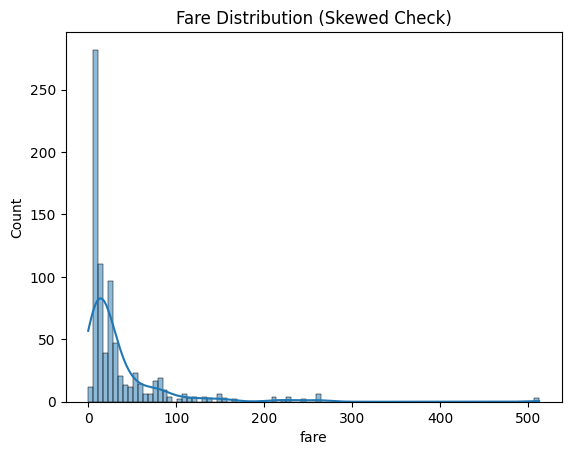

In [3]:
# NUMPY USAGE: outlier detection using Z-scores manually
# We want to see how 'fare' is distributed. Is it skewed?
fare_values = df['fare'].dropna().values # Extract numpy array

mean_fare = np.mean(fare_values)
std_fare = np.std(fare_values)

# Find fares that are 3 standard deviations away (Outliers)
outliers = fare_values[np.abs(fare_values - mean_fare) > 3 * std_fare]
print(f"Max Fare: {np.max(fare_values)}")
print(f"Number of extreme outliers (3 sigma): {len(outliers)}")

# Visual Check
sns.histplot(df['fare'], kde=True)
plt.title('Fare Distribution (Skewed Check)')
plt.show()

## Cell 4: Feature Engineering (Vectorized Logic)

Uses np.where and np.select to create new columns significantly faster than standard loops.

In [ ]:
# LOGIC: If a person is alone (no siblings/spouse/parents), they might have lower survival.
df['family_size'] = df['sibsp'] + df['parch']

# Syntax: np.where(condition, value_if_true, value_if_false)
df['is_alone'] = np.where(df['family_size'] == 0, 1, 0)

# LOGIC: Create a complexity tier for Age using np.select (like SQL CASE WHEN)
conditions = [
    (df['age'] < 12),
    (df['age'] >= 12) & (df['age'] < 60),
    (df['age'] >= 60)
]
choices = ['child', 'adult', 'senior']

df['age_group'] = np.select(conditions, choices, default='unknown')

print(df[['age', 'age_group', 'is_alone']].head())

## Cell 5: Smart Cleaning

Decides how to handle missing data based on percentages rather than guessing.

In [ ]:
# Check percentage of missing values
missing_percent = df.isnull().mean() * 100
print(missing_percent[missing_percent > 0])

# DECISION LOGIC:
# 1. 'deck' has too many missing (~77%). DROP it.
# 2. 'age' is missing ~20%. IMPUTE it with Median (robust to outliers).
# 3. 'embarked' is missing very few. DROP rows.

df_clean = df.drop(columns=['deck'])
df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())
df_clean = df_clean.dropna(subset=['embarked_town'])

print("Shape after cleaning:", df_clean.shape)

## Cell 6: Mathematical Transformations

Normalizes skewed data (like money) to help the model learn better.

In [ ]:
# 'Fare' was highly skewed. Let's apply Log transformation.
# We use np.log1p (log(1+x)) to avoid errors with 0 values.
df_clean['fare_log'] = np.log1p(df_clean['fare'])

# Compare variances
print(f"Original Variance: {np.var(df_clean['fare']):.2f}")
print(f"Log Variance: {np.var(df_clean['fare_log']):.2f}")

## Cell 7: Final Prep (Encoding & Splitting)

Prepares the final arrays for Machine Learning.

In [ ]:
# Convert 'sex' to binary
df_clean['sex_binary'] = np.where(df_clean['sex'] == 'male', 0, 1)

# One-Hot Encode 'embarked_town' and 'class'
df_final = pd.get_dummies(df_clean, columns=['embarked_town', 'class'], drop_first=True)

# Select Features for the model
features = ['pclass', 'sex_binary', 'age', 'sibsp', 'parch', 'fare_log', 'is_alone']
X = df_final[features]
y = df_final['survived']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)